In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import importlib
warnings.filterwarnings('ignore')

In [2]:
import analysis.data.dataframe_creation as dataframe_creation
importlib.reload(dataframe_creation)
from analysis.data.dataframe_creation import pipeline
sd = "2014-01-01"
ed = "2024-01-01"
dataset = pipeline(sd, ed)

[*********************100%***********************]  1 of 1 completed


Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

6 Failed downloads:
['BF.B', 'J']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-01-01 -> 2024-01-01)')
['GEV', 'SW', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2014-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1388552400, endDate = 1704085200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')



The following tickers had more than 20% of NaN values, therefore they're removed:
{'INVH', 'HWM', 'CEG', 'GEHC', 'KVUE', 'FOXA', 'CARR', 'VLTO', 'BF.B', 'OTIS', 'ABNB', 'GEV', 'PLTR', 'J', 'CTVA', 'DAY', 'FOX', 'DOW', 'MRNA', 'BRK.B', 'UBER', 'VST', 'SW', 'SOLV', 'CRWD', 'DELL', 'VICI', 'LW', 'IR', 'FTV'}

Null values: False
NaN values: False

Creating features


Removing stocks that have more than one NaN column


The dataset has 431 assets
The dataset has 24 predictors:
Ticker
Yavg_return
Yavg_volatility
mkt_corr
1Y_momentum
Davg_span
Davg_volume
Davg_Kurtosis
Davg_Skewness
D_eVaR
D_eCVaR
Sharpe_ratio
totalEsg
environmentScore
socialScore
governanceScore
industry
beta
ROA
ROE
est_ROI
profitMargins
P/B
earningsGrowth
forwardPE


Dataset creation finished



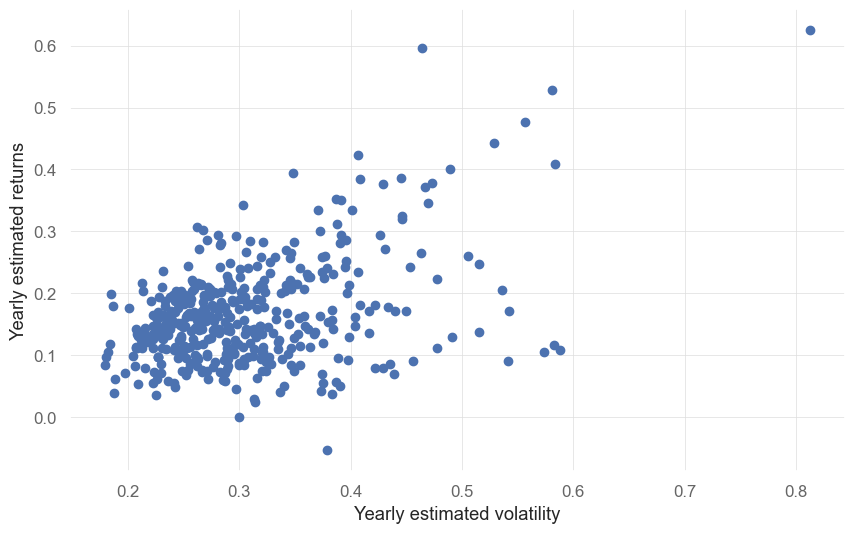

In [3]:
plt.scatter(dataset["Yavg_volatility"], dataset["Yavg_return"])
plt.xlabel("Yearly estimated volatility")
plt.ylabel("Yearly estimated returns")
plt.show()

In [4]:
outliers = outliers = dataset[
    (dataset["Yavg_volatility"] > 0.8)]["Ticker"].unique()
final_dataframe = dataset[~dataset["Ticker"].isin(outliers)]
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,mkt_corr,1Y_momentum,Davg_span,Davg_volume,Davg_Kurtosis,Davg_Skewness,D_eVaR,...,governanceScore,industry,beta,ROA,ROE,est_ROI,profitMargins,P/B,earningsGrowth,forwardPE
1,AAPL,0.281721,0.283805,0.744122,49.375949,1.598720,1.366662e+08,5.549783,-0.033994,-0.028289,...,8.72,Technology,1.240,0.21464,1.57413,0.026440,0.23971,62.649323,-0.341,28.483185
2,ABBV,0.186547,0.267321,0.482775,-0.817885,1.559139,7.681980e+06,10.897025,-0.598636,-0.026959,...,8.62,Biotechnology,0.613,0.07720,0.56407,0.015635,0.09223,53.882210,-0.123,13.364669
3,ABT,0.152782,0.234091,0.669698,1.778578,1.266991,6.174167e+06,6.860927,-0.205403,-0.023649,...,6.56,Health Care,0.722,0.06488,0.14840,0.025887,0.13992,5.575749,0.146,22.552586
4,ACGL,0.169788,0.259333,0.608845,17.683401,0.672525,1.657923e+06,16.083008,-0.341138,-0.026197,...,8.78,Insurance,0.613,0.04861,0.30441,0.161951,0.33859,1.626131,0.362,10.433155
5,ACN,0.193459,0.241761,0.793303,32.828524,3.150631,2.295803e+06,6.974805,0.192868,-0.024283,...,4.01,Technology,1.245,0.11627,0.26675,0.030172,0.11194,8.508687,0.236,27.623913


In [5]:
stock_data_clustering = final_dataframe[["Yavg_return",	"Yavg_volatility"]]

stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 1 to 471
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Yavg_return      430 non-null    float64
 1   Yavg_volatility  430 non-null    float64
dtypes: float64(2)
memory usage: 10.1 KB


In [6]:
from sklearn.preprocessing import MinMaxScaler
for attr in stock_data_clustering.columns:
    scaler = MinMaxScaler()
    stock_data_clustering[attr] = scaler.fit_transform(stock_data_clustering[attr].values.reshape(-1, 1)).flatten()

In [7]:
from analysis.clustering.kmeans_clustering import run_kmeans
clusters = range(2, 20)
runs = 60
meanDistortions, sil_score, inertias = run_kmeans(clusters, stock_data_clustering, runs)

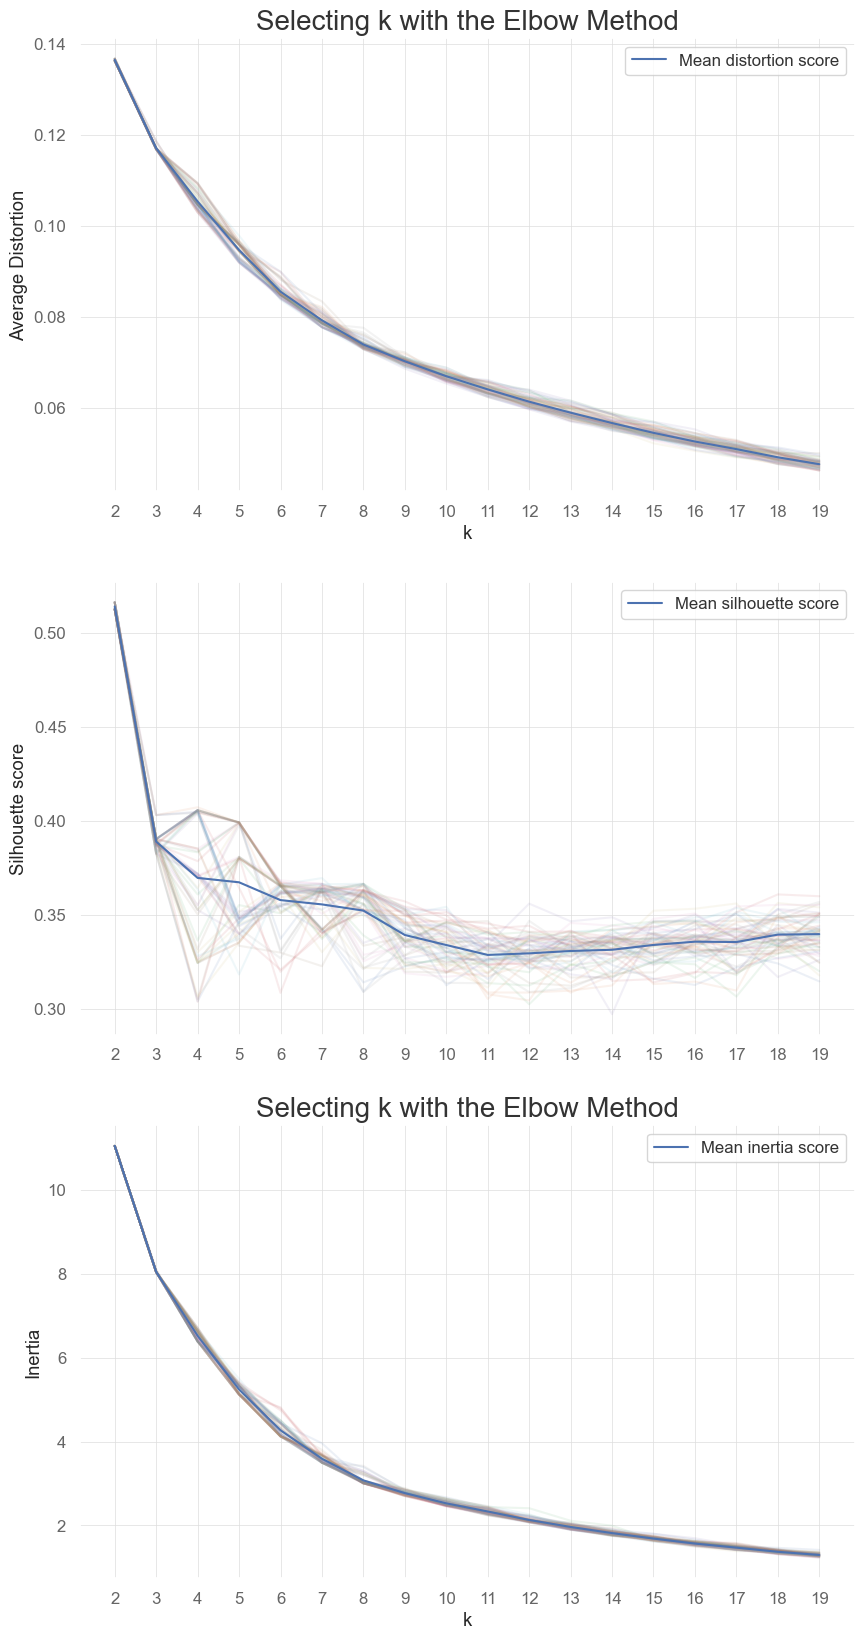

In [8]:
from analysis.data.plotting import plot_kmeans
plot_kmeans(runs, clusters, meanDistortions, sil_score, inertias)

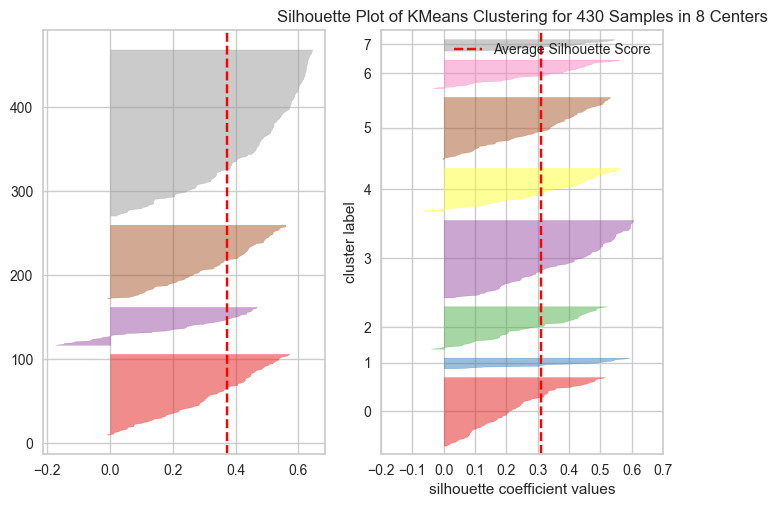

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 430 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [9]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
plt.subplot(1,2,1)
n1 = 4
visualizer = SilhouetteVisualizer(KMeans(n1, random_state=np.argmax(sil_score[n1-1])))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
n2 = 8
visualizer = SilhouetteVisualizer(KMeans(n2, random_state=np.argmax(sil_score[n2-1])))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [10]:
N_SECTORS = 8
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_SECTORS, random_state=np.argmax(sil_score[N_SECTORS-1]))
kmeans.fit(stock_data_clustering)
final_dataframe["Sector"] = kmeans.labels_
final_dataframe.head()

,Ticker,Yavg_return,Yavg_volatility,mkt_corr,1Y_momentum,Davg_span,Davg_volume,Davg_Kurtosis,Davg_Skewness,D_eVaR,...,industry,beta,ROA,ROE,est_ROI,profitMargins,P/B,earningsGrowth,forwardPE,Sector
1,AAPL,0.281721,0.283805,0.744122,49.375949,1.598720,1.366662e+08,5.549783,-0.033994,-0.028289,...,Technology,1.240,0.21464,1.57413,0.026440,0.23971,62.649323,-0.341,28.483185,5
2,ABBV,0.186547,0.267321,0.482775,-0.817885,1.559139,7.681980e+06,10.897025,-0.598636,-0.026959,...,Biotechnology,0.613,0.07720,0.56407,0.015635,0.09223,53.882210,-0.123,13.364669,5
3,ABT,0.152782,0.234091,0.669698,1.778578,1.266991,6.174167e+06,6.860927,-0.205403,-0.023649,...,Health Care,0.722,0.06488,0.14840,0.025887,0.13992,5.575749,0.146,22.552586,3
4,ACGL,0.169788,0.259333,0.608845,17.683401,0.672525,1.657923e+06,16.083008,-0.341138,-0.026197,...,Insurance,0.613,0.04861,0.30441,0.161951,0.33859,1.626131,0.362,10.433155,5
5,ACN,0.193459,0.241761,0.793303,32.828524,3.150631,2.295803e+06,6.974805,0.192868,-0.024283,...,Technology,1.245,0.11627,0.26675,0.030172,0.11194,8.508687,0.236,27.623913,5


In [13]:
cluster_profile = final_dataframe.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = final_dataframe.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]

max_cols = ["beta", "D_eSkewness", "Yavg_return", "Sharpe_ratio", "Davg_volume", "ROE", "ROA", "est_ROI", "profitMargins", "earningsGrowth"]
min_cols = ["beta", "Davg_span", "D_eCurtosis", "Yavg_volatility", "D_eVaR", "D_eCVaR", 
            "totalEsg", "environmentScore", "socialScore", "governanceScore"]

# Custom function for styling
def highlight_extremes(val, col_name):
    max_color = "background-color: green"
    min_color = "background-color: blue"
    
    if col_name in max_cols and val == cluster_profile[col_name].max():
        return max_color
    elif col_name in min_cols and val == cluster_profile[col_name].min():
        return min_color
    return ""

cluster_profile.style.apply(lambda x: [highlight_extremes(v, x.name) for v in x], axis=0)
# cluster_profile.style.highlight_max(color="green", axis=0, subset=["beta", "D_eSkewness",	"Yavg_return", "Sharpe_ratio", "Davg_volume"])
# cluster_profile.style.highlight_min(color="green", axis=0, subset=["beta", "Davg_span", "D_eCurtosis",	"Yavg_volatility", "D_eVaR", "D_eCVaR", "totalEsg",	"environmentScore",	"socialScore",	"governanceScore"])

,Yavg_return,Yavg_volatility,mkt_corr,1Y_momentum,Davg_span,Davg_volume,Davg_Kurtosis,Davg_Skewness,D_eVaR,D_eCVaR,Sharpe_ratio,totalEsg,environmentScore,socialScore,governanceScore,beta,ROA,ROE,est_ROI,profitMargins,P/B,earningsGrowth,forwardPE,Count
Sector,,,,,,,,,,,,,,,,,,,,,,,,
0,0.136288,0.283301,0.614509,10.944776,2.166277,3891695.224179,14.142020,-0.068350,-0.028814,-0.045061,0.410475,20.405176,5.126706,9.419765,5.858588,1.019776,0.057562,0.287172,0.048529,0.128788,5.497165,0.197610,18.050221,85
1,0.172715,0.518795,0.494027,35.279320,2.007732,9484841.551925,25.299539,-0.065642,-0.053070,-0.088532,0.294365,27.287143,12.624286,9.756429,4.907857,1.973929,0.060146,0.262482,0.073331,0.147451,4.572166,0.175000,12.445001,14
2,0.095851,0.325670,0.598567,11.698789,1.549023,5721782.878438,14.129130,-0.117281,-0.033364,-0.052732,0.232909,20.545472,5.589057,8.935660,6.020189,1.166170,0.030851,0.093462,0.024277,0.086252,3.341163,0.761467,17.240553,53
3,0.117252,0.226713,0.549353,-1.283038,1.507544,4291856.158039,13.770312,-0.218949,-0.023026,-0.036330,0.428967,21.424583,7.063958,9.100312,5.260625,0.677168,0.055126,0.296764,0.043454,0.138628,11.405606,0.332000,20.181096,96
4,0.257451,0.355746,0.598460,47.833609,4.524650,5598217.504968,11.212224,0.095353,-0.035839,-0.054964,0.667473,20.074074,5.478889,9.121481,5.473889,1.257907,0.091972,0.542616,0.039188,0.149201,12.425006,0.235058,26.507240,54
5,0.205649,0.262925,0.632926,24.445105,2.658025,5246607.058818,17.238800,0.208213,-0.026427,-0.040790,0.706091,18.776623,4.327013,8.764805,5.684286,0.915208,0.086841,0.389723,0.034012,0.176450,12.416818,0.096554,26.976389,77
6,0.128022,0.396462,0.536556,13.575122,1.887697,5204553.875287,16.021069,-0.100670,-0.040572,-0.064233,0.272466,21.337500,6.972500,8.633056,5.731389,1.314250,0.049727,0.207509,0.052744,0.134091,4.376240,0.239069,20.450054,36
7,0.411204,0.479637,0.532572,66.882150,3.541196,45988188.693694,18.399512,0.380225,-0.048066,-0.073081,0.815624,19.528667,4.464667,8.615333,6.452000,1.574467,0.130787,0.311232,0.022330,0.230183,15.215318,0.343643,37.194033,15


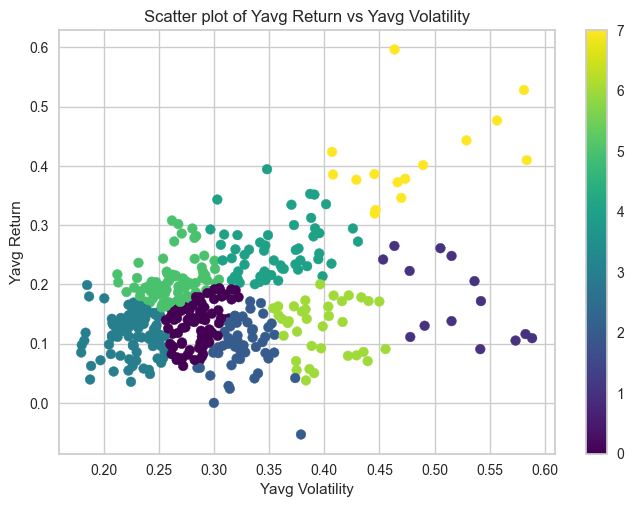

In [14]:
plt.scatter(
    final_dataframe["Yavg_volatility"], 
    final_dataframe["Yavg_return"], 
    c=final_dataframe["Sector"],  # Use c for color mapping
    cmap='viridis',  # Optional: Choose a colormap
    
)

# Add labels and title
plt.xlabel("Yavg Volatility")
plt.ylabel("Yavg Return")
plt.title("Scatter plot of Yavg Return vs Yavg Volatility")
plt.colorbar()
# Show the plot
plt.show()

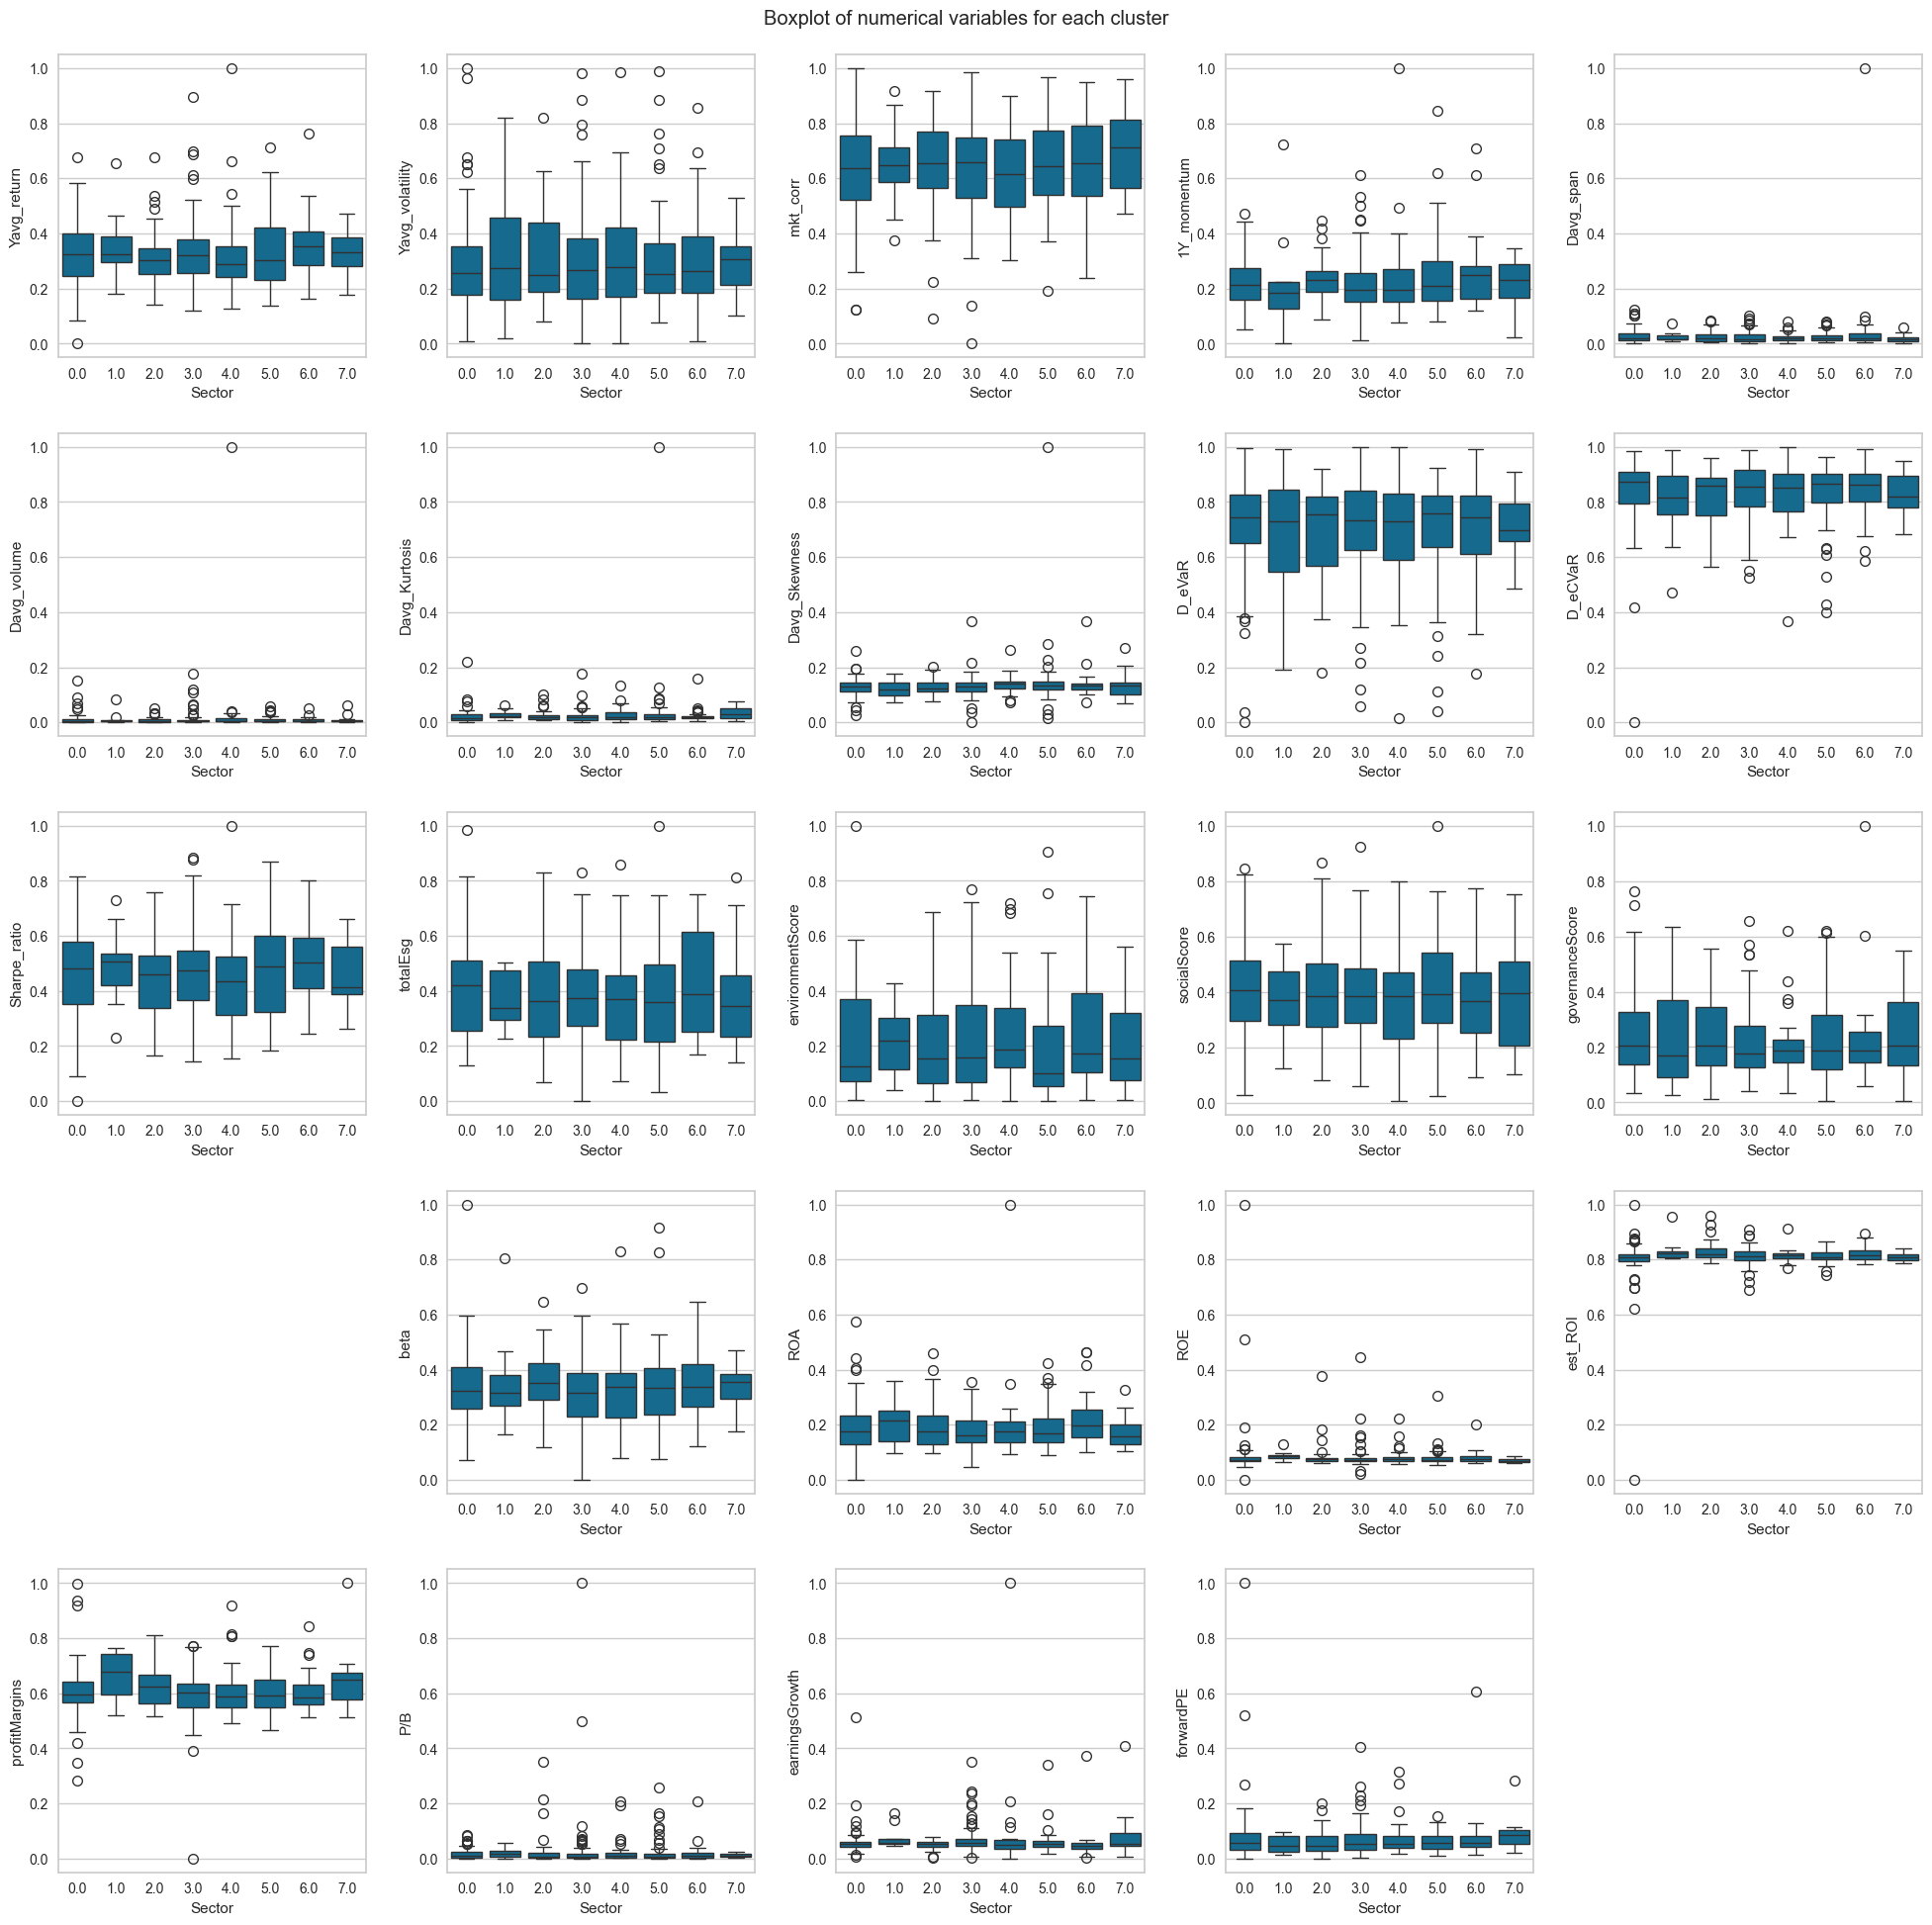

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaled_data = pd.DataFrame()
for attr in final_dataframe.select_dtypes(include=["float64", "int64"]).columns:
    scaler = MinMaxScaler()
    scaled_data[attr] = scaler.fit_transform(final_dataframe[attr].values.reshape(-1, 1)).flatten()
scaled_data["Sector"] = final_dataframe["Sector"]
plt.figure(figsize=(20, 20))
import seaborn as sns
plt.suptitle("Boxplot of numerical variables for each cluster")
i = 1
for i, variable in enumerate(final_dataframe):
  if variable not in ["Ticker", "industry", "Sector"]:
    plt.subplot(5, 5, i)
    sns.boxplot(data=scaled_data, x="Sector", y=variable)
    i += 1

plt.tight_layout(pad=2.0)

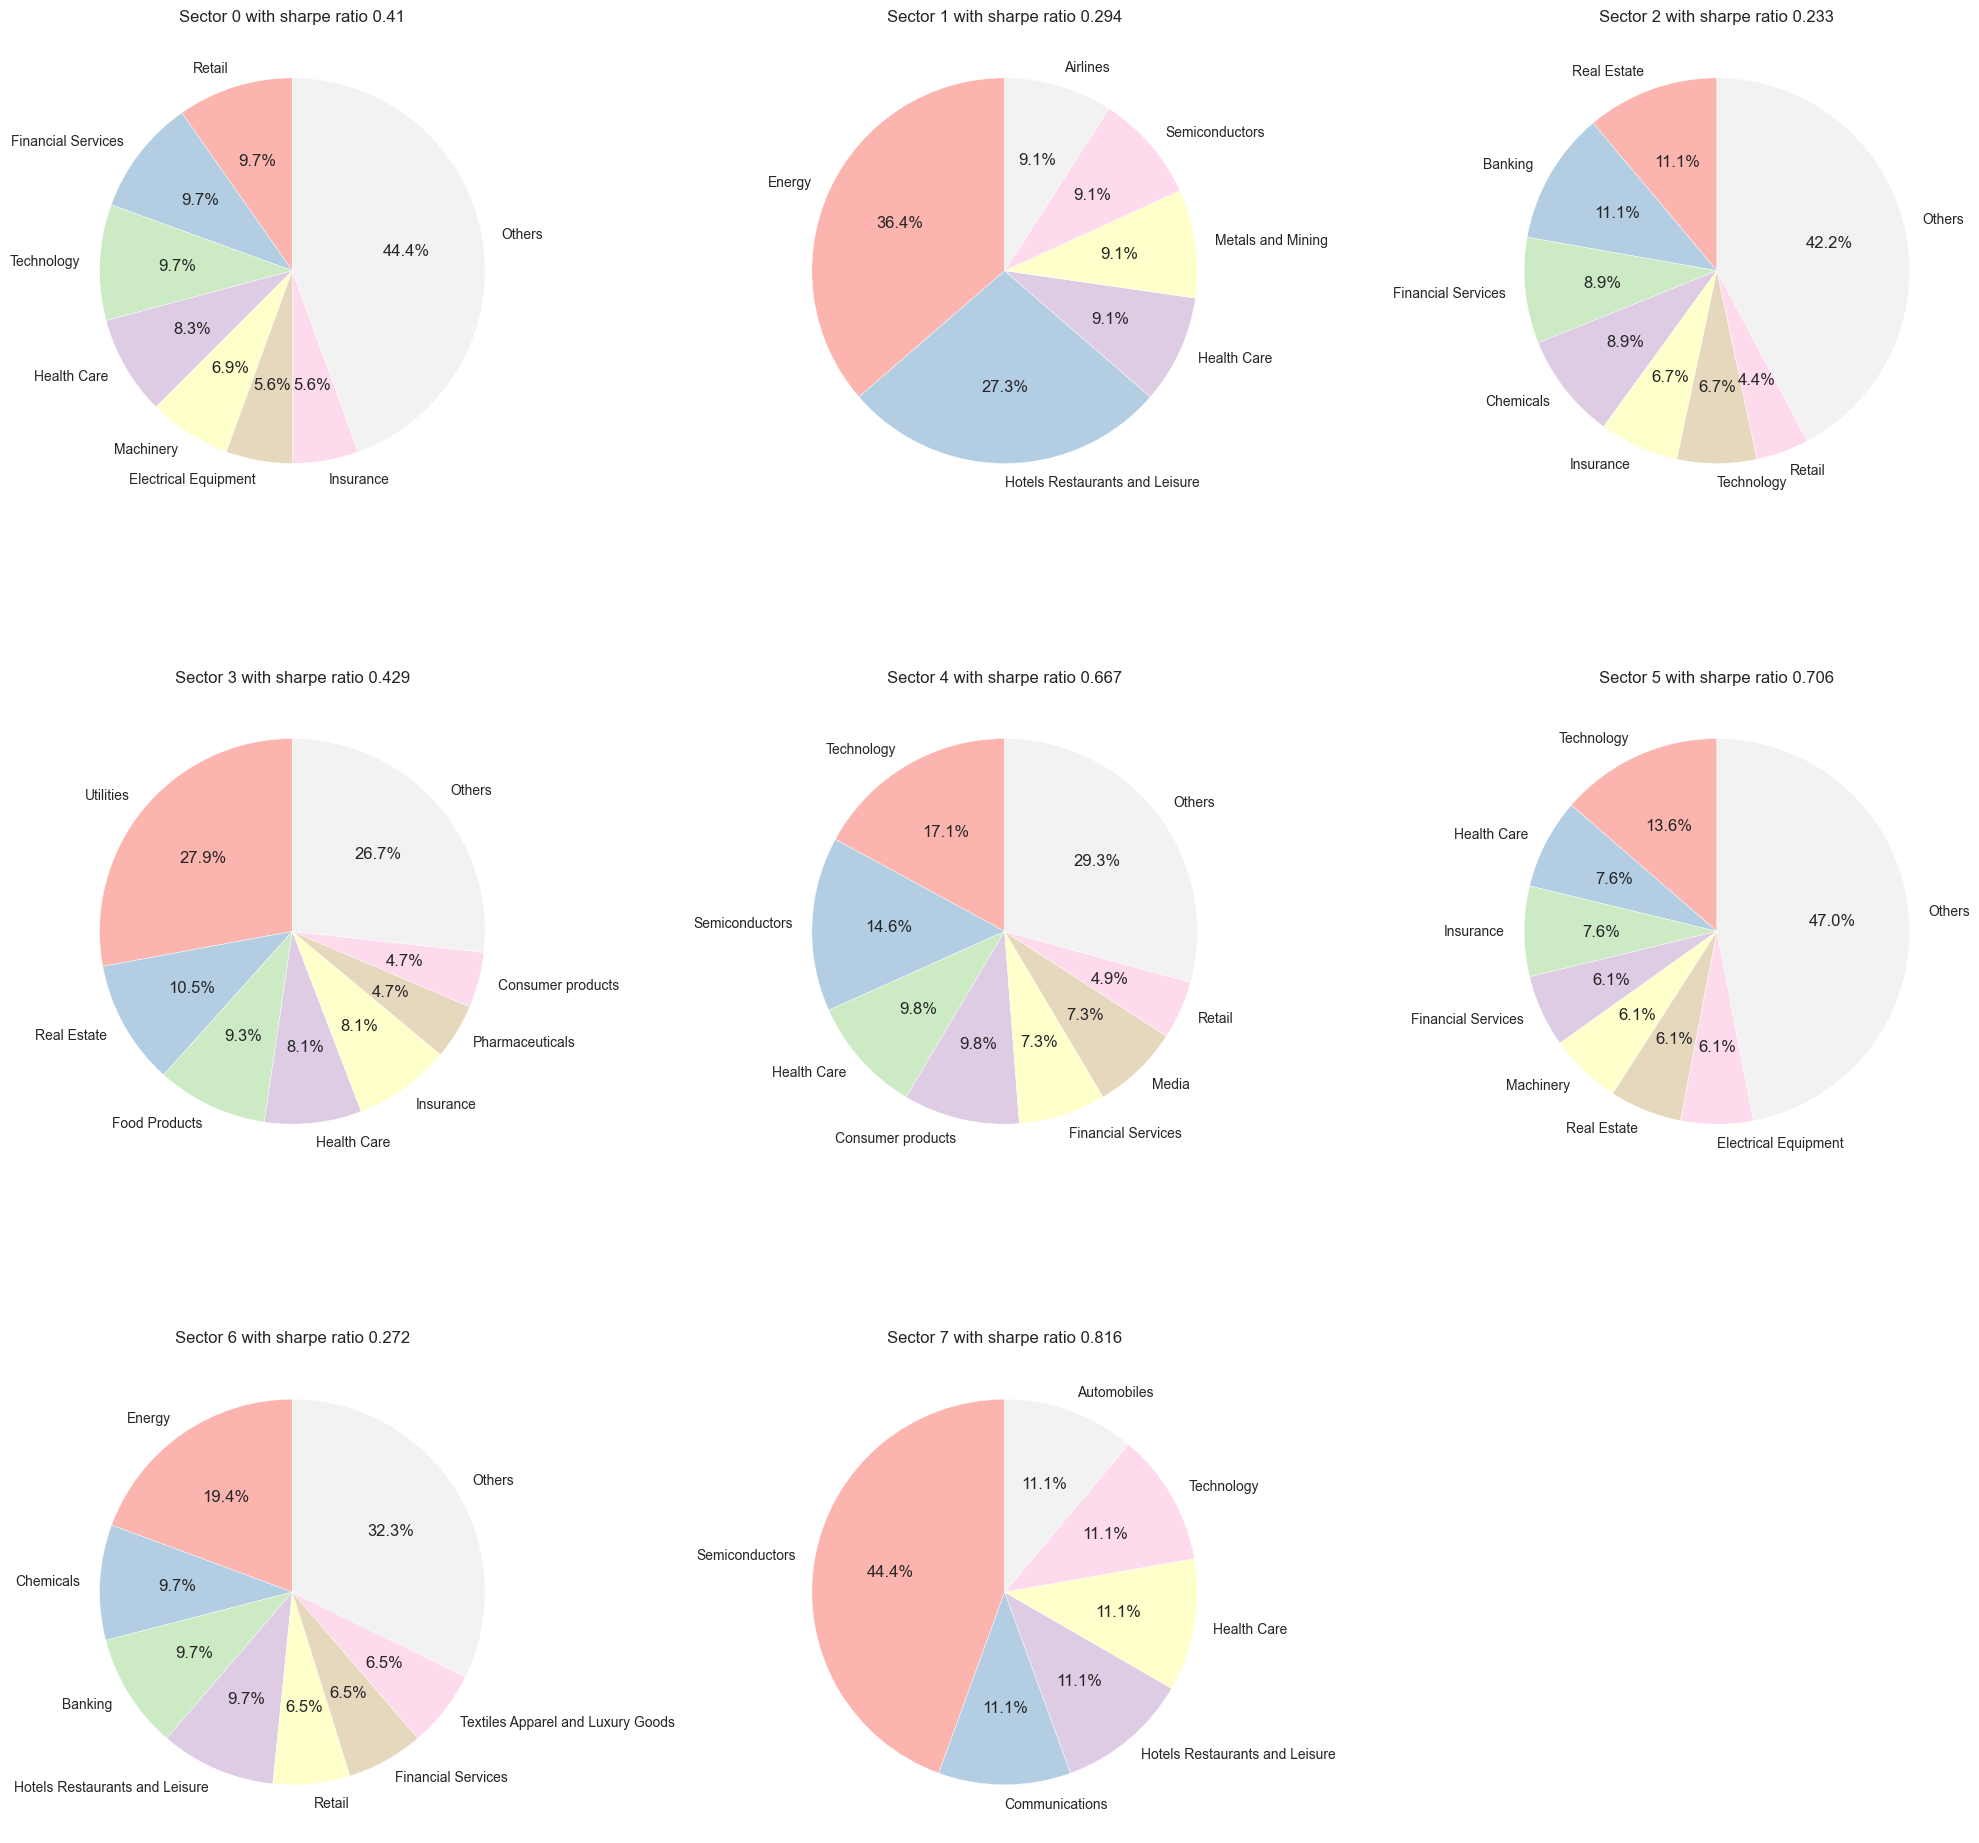

In [17]:
MAX_LABELS = 7
from analysis.data.plotting import plot_cluster_industry
plot_cluster_industry(MAX_LABELS, final_dataframe, cluster_profile)


In [18]:
from analysis.data.dataframe_creation import create_portfolio_clustered
portfolio_ret, asset_ret = create_portfolio_clustered(sd, ed, final_dataframe, list(final_dataframe["Ticker"]), w = "uniform")


[*********************100%***********************]  430 of 430 completed


Null values: False
Null values: False
Cluster Portfolios uniformly built among assets


In [21]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


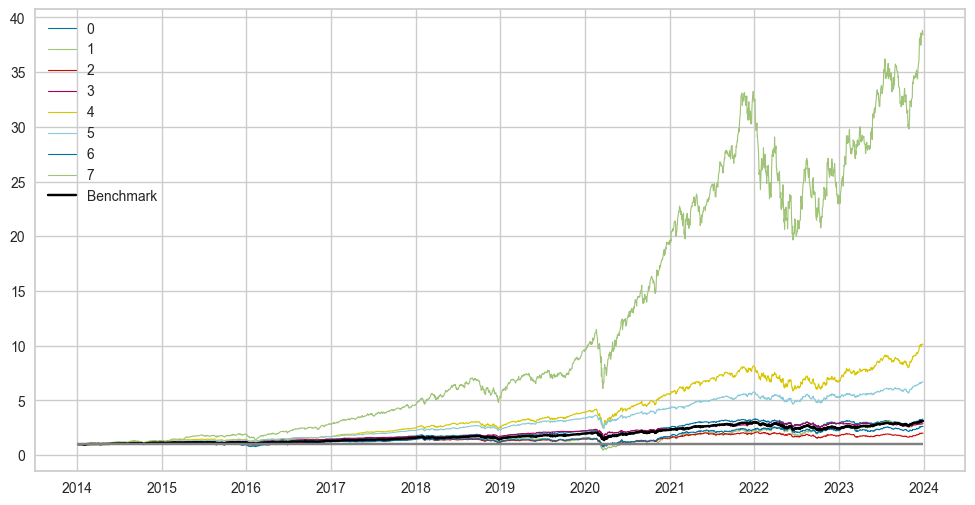

In [22]:
import analysis.data.plotting as plotting
importlib.reload(plotting)
from analysis.data.plotting import portfolio_evolution_time
portfolio_evolution_time(portfolio_ret.reset_index(), benchmark.reset_index())

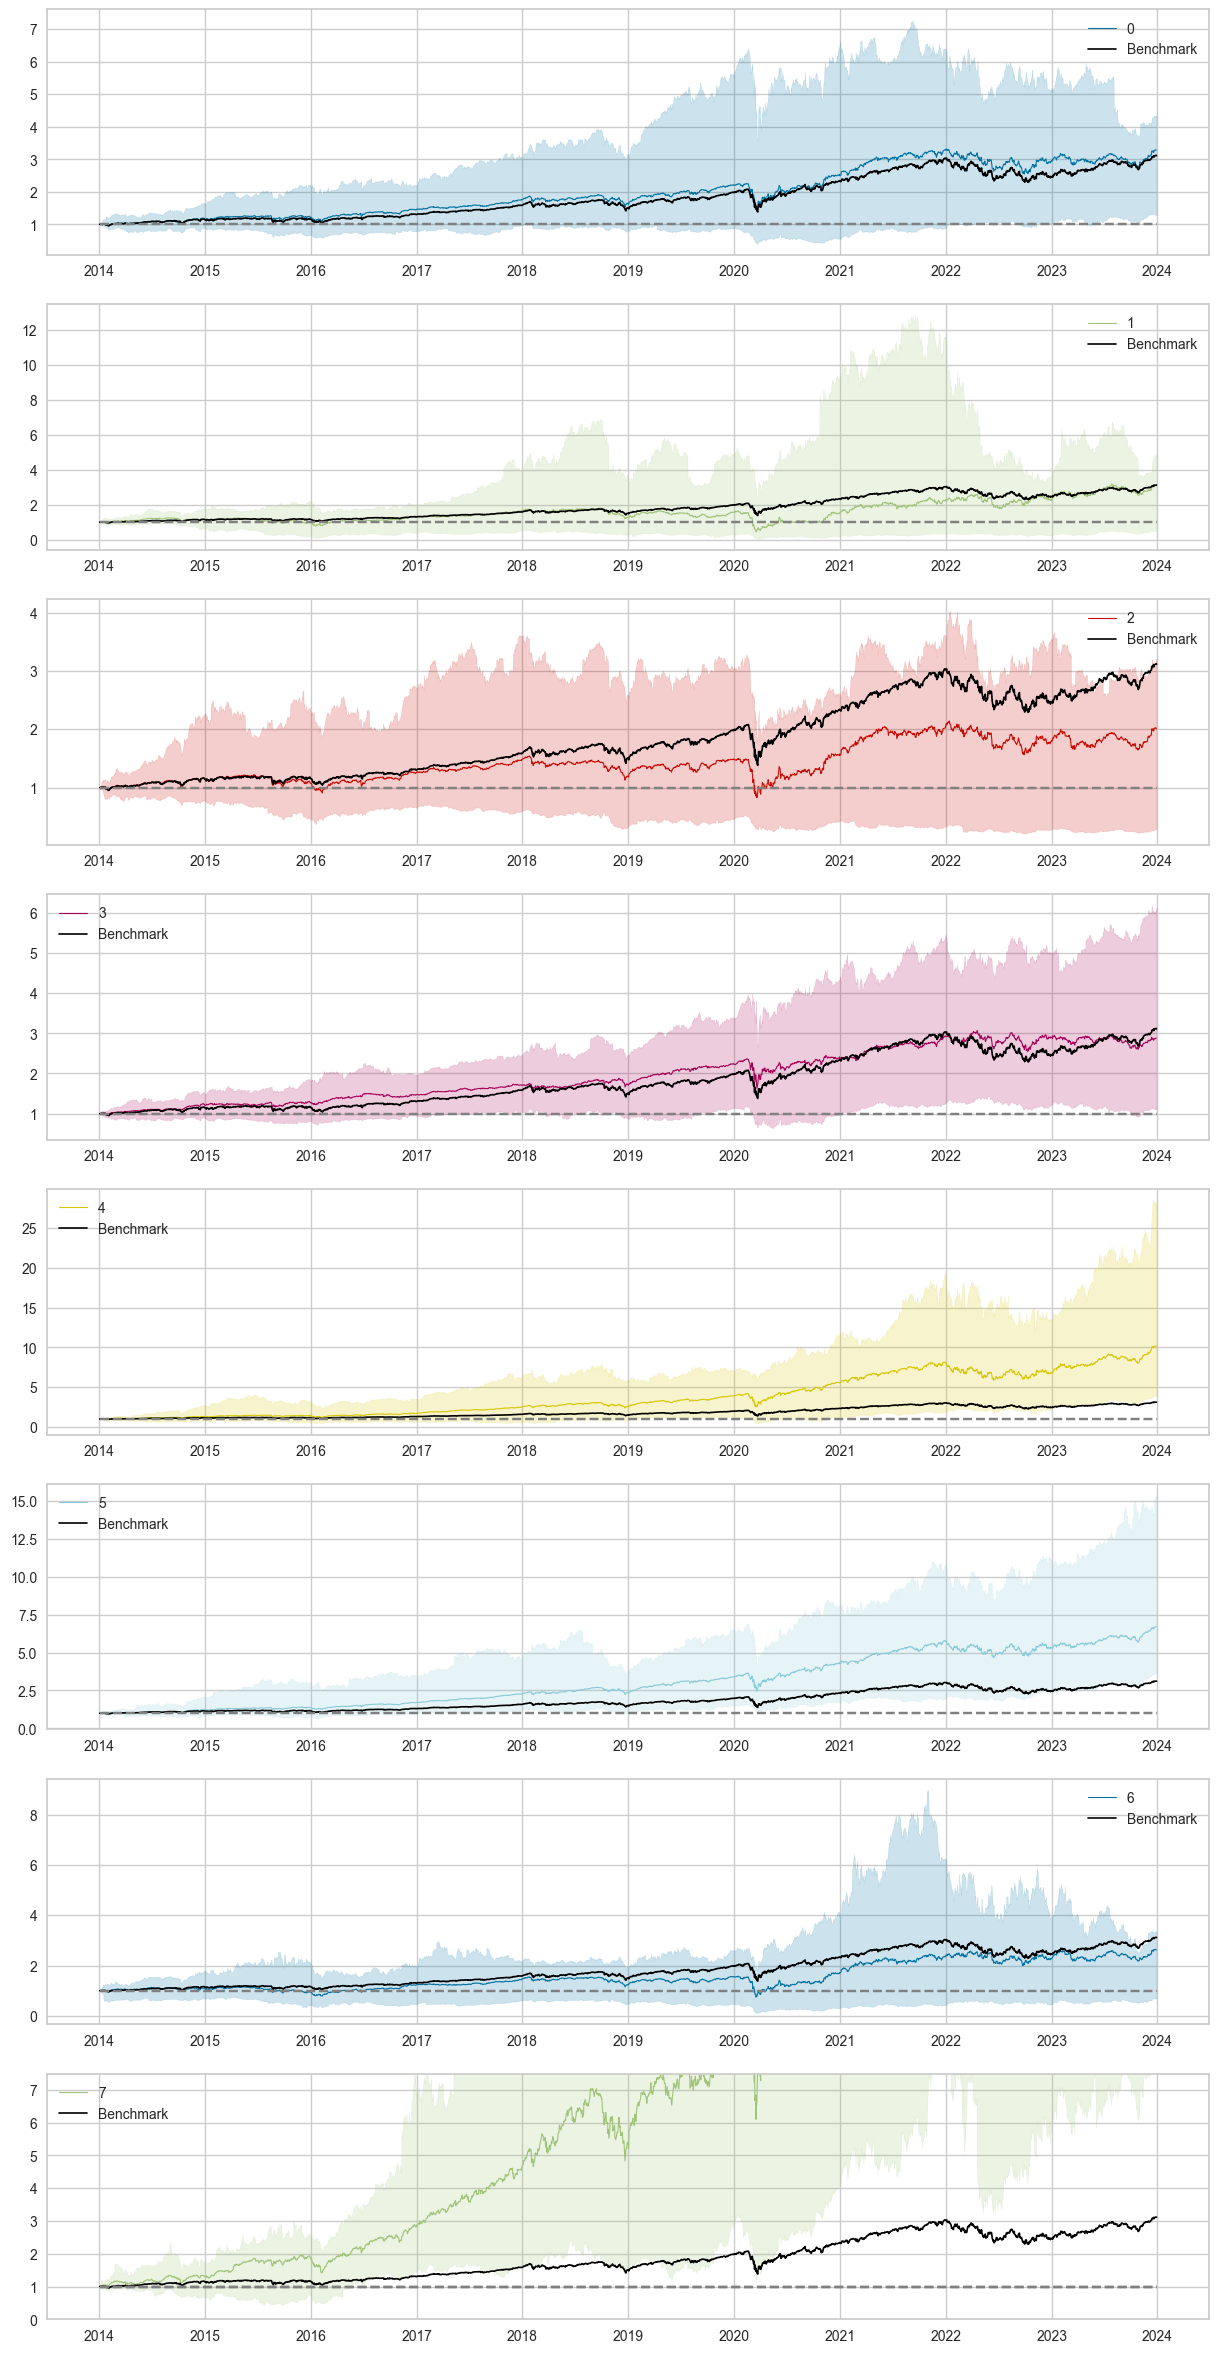

In [23]:
from analysis.data.plotting import portfolio_span
portfolio_span(asset_ret, portfolio_ret, final_dataframe, benchmark, N_SECTORS)

In [24]:
from analysis.data.dataframe_creation import create_portfolio_clustered
sd_test = ed
ed_test = "2025-01-10"
portfolio_ret_t, asset_ret_t = create_portfolio_clustered(sd_test, ed_test, final_dataframe,
                                                           list(final_dataframe["Ticker"]), w="sharpe")

[*********************100%***********************]  430 of 430 completed


Null values: False
Null values: False
Cluster Portfolios based on sharpe ratio


In [25]:
benchmark_t = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2024-01-03  2024-01-03
End Period                 2025-01-08  2025-01-08
Risk-Free Rate             2.0%        2.0%
Time in Market             100.0%      100.0%

Cumulative Return          22.28%      26.32%
CAGR﹪                     21.88%      25.84%

Sharpe                     1.33        1.73
Prob. Sharpe Ratio         87.3%       93.75%
Smart Sharpe               1.3         1.7
Sortino                    1.94        2.5
Smart Sortino              1.9         2.45
Sortino/√2                 1.37        1.77
Smart Sortino/√2           1.34        1.73
Omega                      1.24        1.24

Max Drawdown               -8.26%      -8.41%
Longest DD Days            98          64
Volatility (ann.)          14.19%      12.58%
R^2                        0.86        0.86
Information Ratio          -0.04       -0.04
Calmar                     2.65        3.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-07-17,2024-08-05,2024-08-23,37,-8.256443,-7.889134
2,2024-04-01,2024-04-19,2024-07-08,98,-6.981854,-6.298797
3,2024-12-03,2024-12-19,2025-01-08,36,-6.807741,-6.520483
4,2024-09-03,2024-09-06,2024-09-16,13,-4.470089,-3.313057
5,2024-11-12,2024-11-15,2024-11-22,10,-2.988220,-2.436626


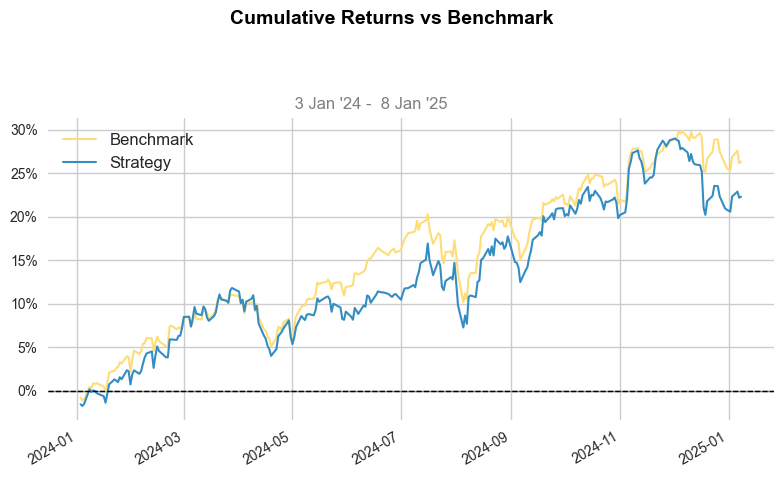

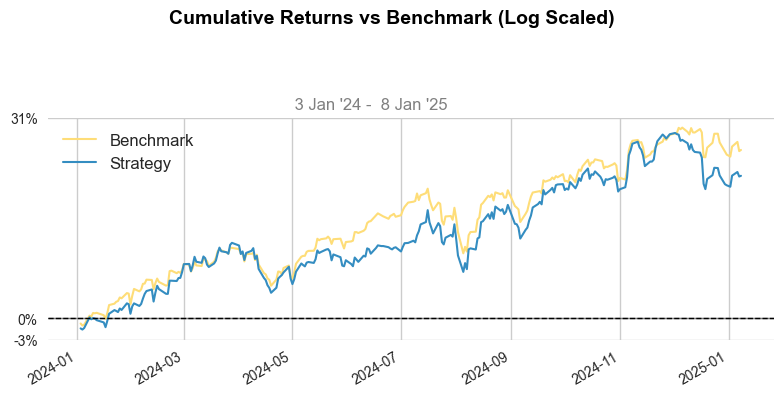

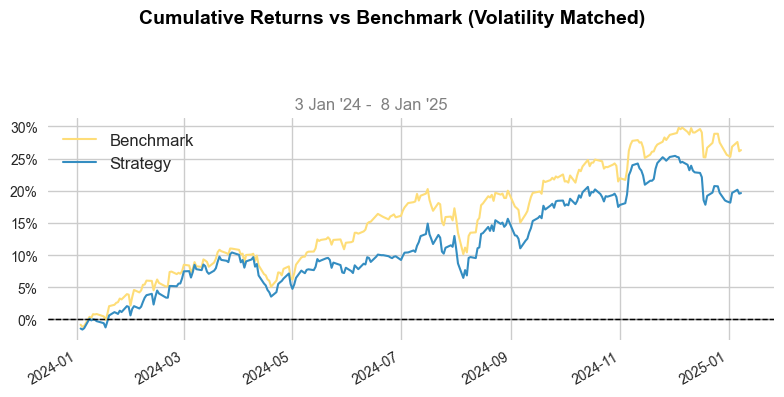

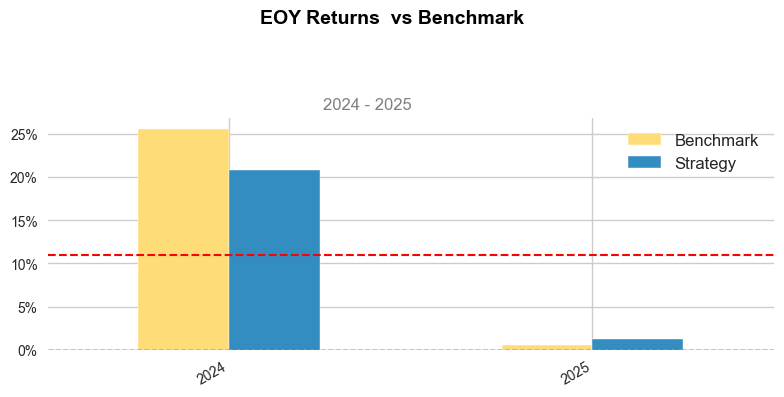

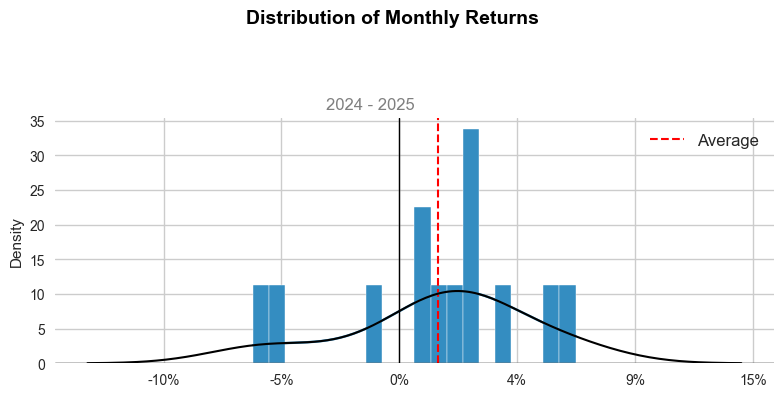

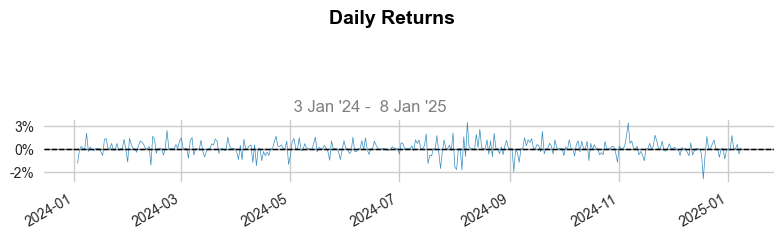

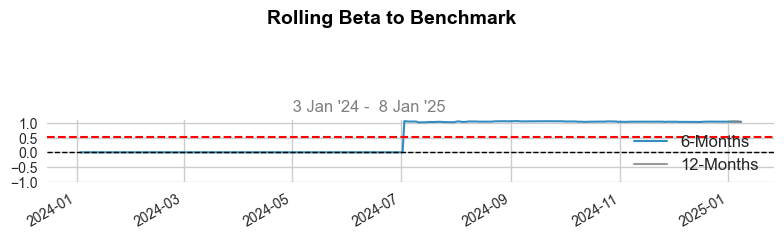

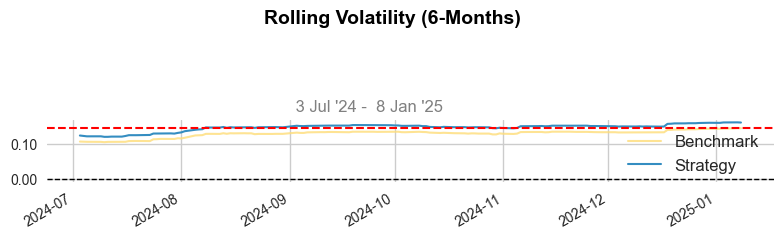

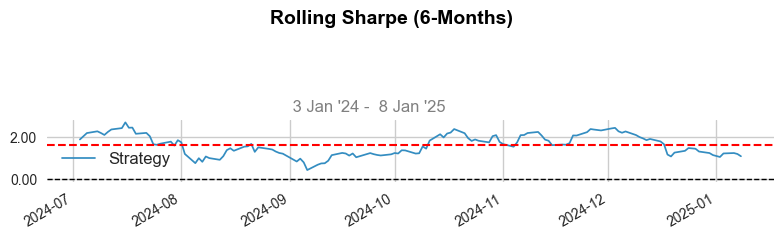

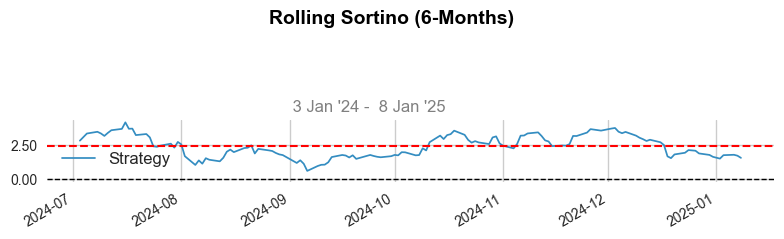

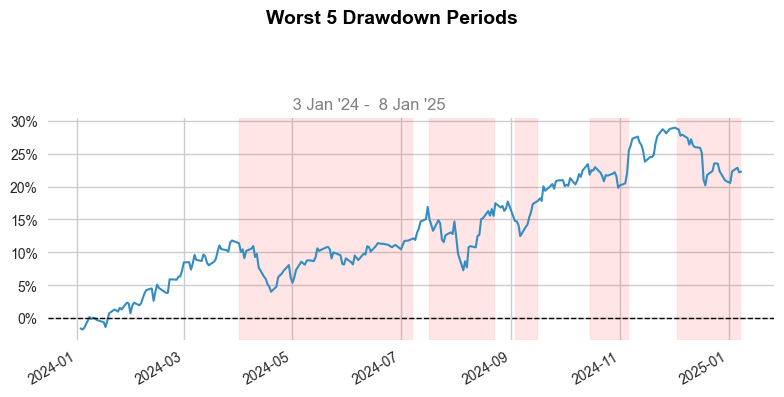

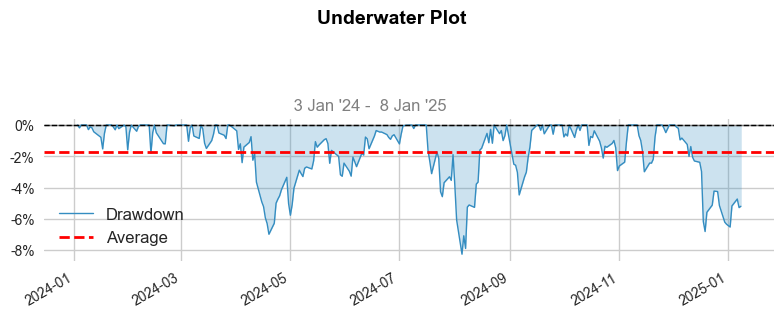

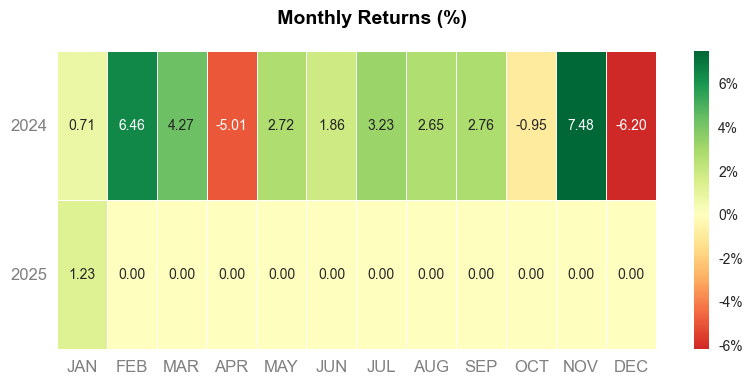

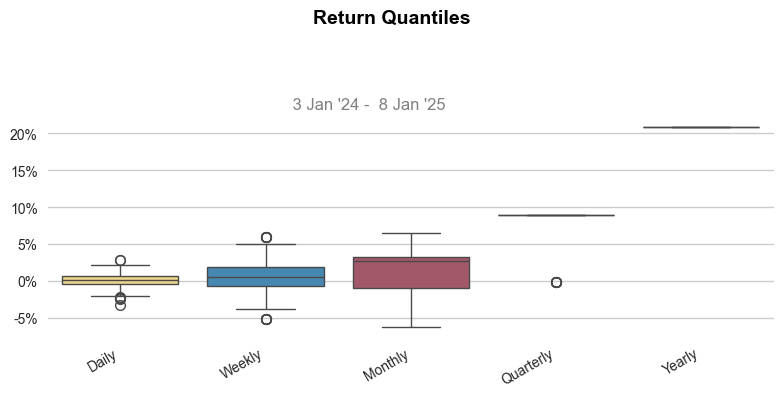

In [27]:
import quantstats as qs
def weights(ratios, cluster, pow, thresh):
    w = np.array(ratios["Sharpe_ratio"] > thresh)*ratios["Sharpe_ratio"]
    ratios["weights"] = np.power(w, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

returns = np.zeros(len(portfolio_ret_t))
cp = cluster_profile.reset_index()
for i in portfolio_ret_t.columns:
        weight = weights(cp[["Sector", "Sharpe_ratio"]], i, 1, 0.25).values[0]
        returns += weight*portfolio_ret_t[i] 
        
portfolio_performance = pd.DataFrame(returns).reset_index()
portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])
portfolio_performance.set_index("Date", inplace=True)
portfolio_performance.columns = ["Returns"]

qs.reports.full(
    portfolio_performance["Returns"],
    benchmark=benchmark_t.pct_change().dropna(),
    rf=0.02,
)

In [49]:
print(qs.__version__)

0.0.64


In [34]:

print("Pandas Version:", pd.__version__)
print("Quantstats Version:", qs.__version__)

Pandas Version: 1.5.3
Quantstats Version: 0.0.64
